Extracting NMR shifts:   0%|          | 0/32937 [00:00<?, ?it/s]

Total number of 13C shifts: 356098
Mean shift: 95.54 ppm
Median shift: 115.90 ppm
Standard deviation: 51.61 ppm
Range: -45.80 to 333.80 ppm


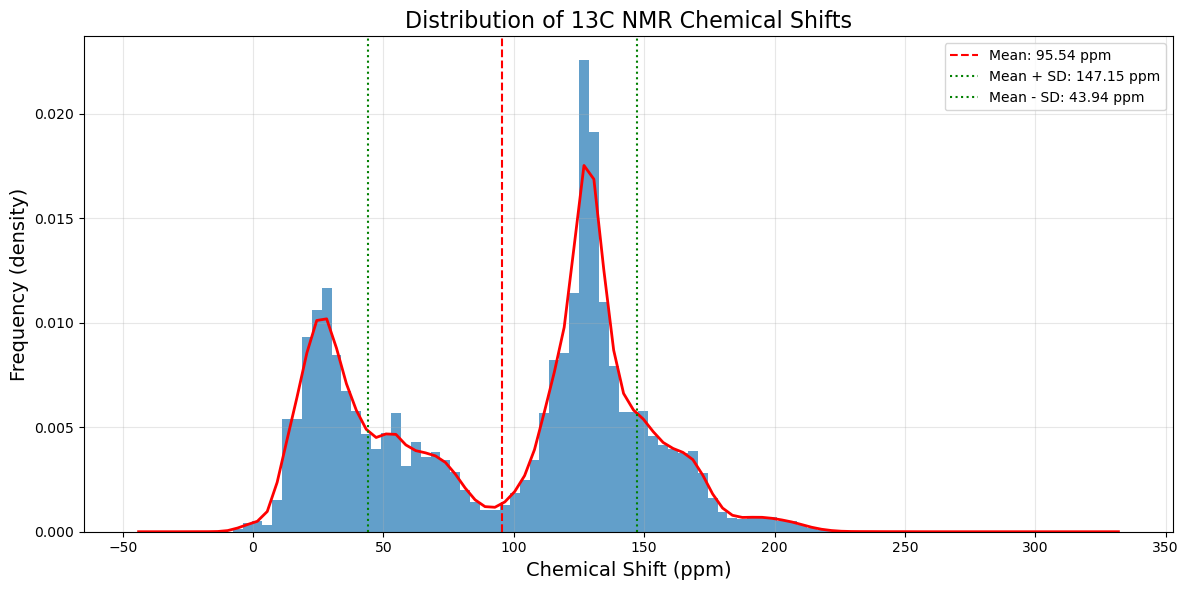

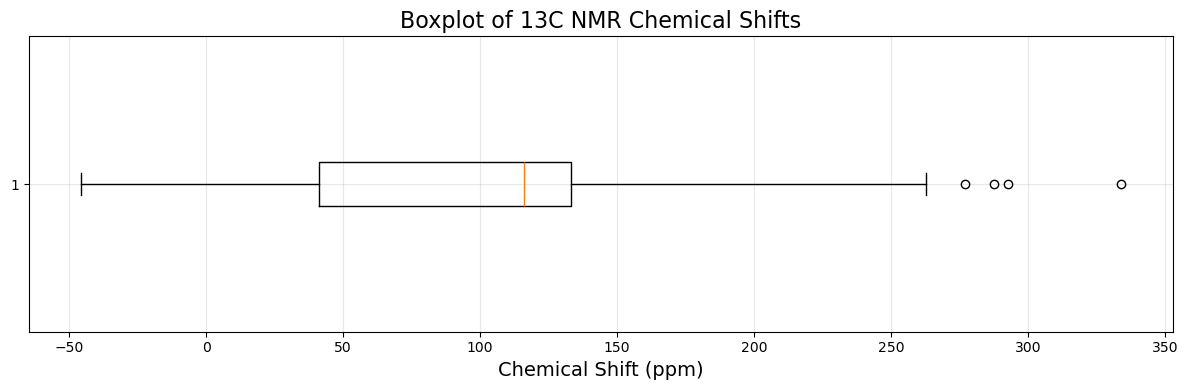

Number of potential outliers: 4
Percentage of outliers: 0.00%
Shifts in typical 13C range (0-220 ppm): 355102 (99.72%)
Negative shifts: 870 (0.24%)
Very high shifts (>220 ppm): 126 (0.04%)


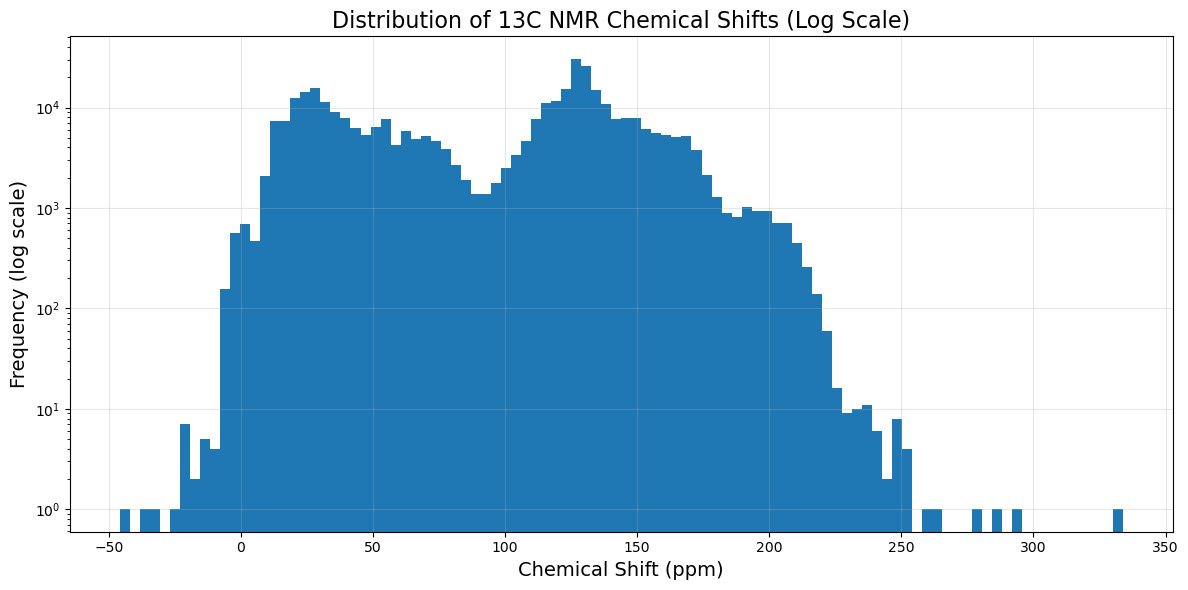

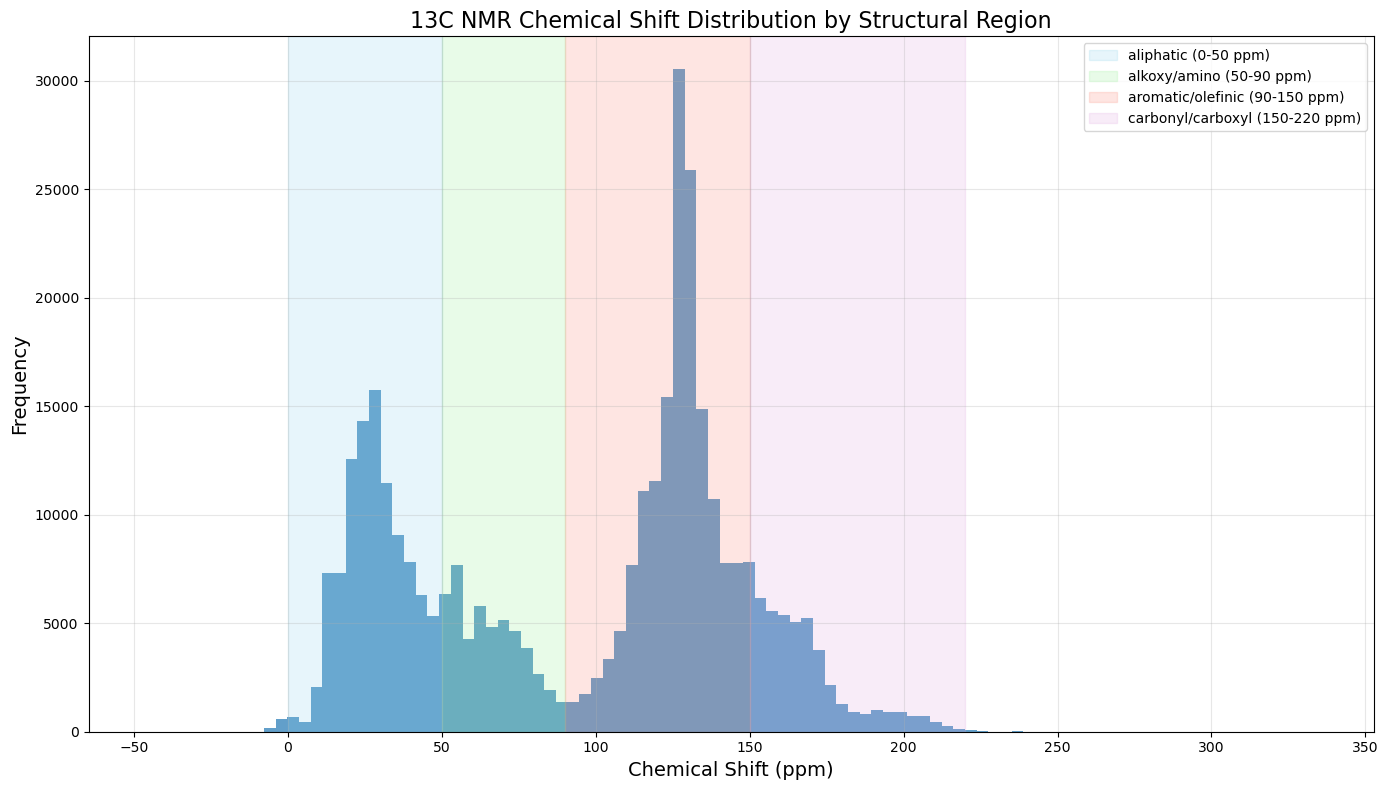

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Path to your HDF5 file
h5_file_path = "../data/processed/processed_data.h5"

# Function to extract all NMR shifts from the dataset
def extract_all_shifts(h5_file_path):
    all_shifts = []
    with h5py.File(h5_file_path, 'r') as f:
        # Get total number of molecules
        total_molecules = len(f.keys())
        
        # Iterate through each molecule
        for mol_key in tqdm(f.keys(), desc="Extracting NMR shifts"):
            mol_group = f[mol_key]
            if 'y' in mol_group:
                # Get the shifts (y values)
                shifts = mol_group['y'][:]
                
                # Filter out NaN values
                valid_shifts = shifts[~np.isnan(shifts)]
                
                # Add to our collection
                all_shifts.extend(valid_shifts)
    
    return np.array(all_shifts)

# Extract all shifts
all_shifts = extract_all_shifts(h5_file_path)

# Calculate statistics
mean_shift = np.mean(all_shifts)
median_shift = np.median(all_shifts)
std_dev = np.std(all_shifts)
min_shift = np.min(all_shifts)
max_shift = np.max(all_shifts)
total_shifts = len(all_shifts)

# Print statistics
print(f"Total number of 13C shifts: {total_shifts}")
print(f"Mean shift: {mean_shift:.2f} ppm")
print(f"Median shift: {median_shift:.2f} ppm")
print(f"Standard deviation: {std_dev:.2f} ppm")
print(f"Range: {min_shift:.2f} to {max_shift:.2f} ppm")

# Create distribution plot using matplotlib
plt.figure(figsize=(12, 6))

# Create histogram
n, bins, patches = plt.hist(all_shifts, bins=100, alpha=0.7, density=True)

# Add KDE-like curve using numpy's histogram and scipy's gaussian_filter if available
try:
    from scipy.ndimage import gaussian_filter1d
    hist, bin_edges = np.histogram(all_shifts, bins=100, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    smoothed = gaussian_filter1d(hist, sigma=1)
    plt.plot(bin_centers, smoothed, 'r-', linewidth=2)
except ImportError:
    # Fall back to simple connecting line if scipy not available
    hist, bin_edges = np.histogram(all_shifts, bins=100, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, hist, 'r-', linewidth=2)

# Add vertical lines for statistics
plt.axvline(mean_shift, color='r', linestyle='--', label=f'Mean: {mean_shift:.2f} ppm')
plt.axvline(mean_shift + std_dev, color='g', linestyle=':', label=f'Mean + SD: {mean_shift + std_dev:.2f} ppm')
plt.axvline(mean_shift - std_dev, color='g', linestyle=':', label=f'Mean - SD: {mean_shift - std_dev:.2f} ppm')

plt.title('Distribution of 13C NMR Chemical Shifts', fontsize=16)
plt.xlabel('Chemical Shift (ppm)', fontsize=14)
plt.ylabel('Frequency (density)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a boxplot using matplotlib
plt.figure(figsize=(12, 4))
plt.boxplot(all_shifts, vert=False)
plt.title('Boxplot of 13C NMR Chemical Shifts', fontsize=16)
plt.xlabel('Chemical Shift (ppm)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check for potential anomalies
# 1. Count extreme values (potential outliers)
q1 = np.percentile(all_shifts, 25)
q3 = np.percentile(all_shifts, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = all_shifts[(all_shifts < lower_bound) | (all_shifts > upper_bound)]
print(f"Number of potential outliers: {len(outliers)}")
print(f"Percentage of outliers: {len(outliers) / len(all_shifts) * 100:.2f}%")

# 2. Distribution in specific ranges
typical_range = all_shifts[(all_shifts >= 0) & (all_shifts <= 220)]
print(f"Shifts in typical 13C range (0-220 ppm): {len(typical_range)} ({len(typical_range)/len(all_shifts)*100:.2f}%)")

negative_shifts = all_shifts[all_shifts < 0]
print(f"Negative shifts: {len(negative_shifts)} ({len(negative_shifts)/len(all_shifts)*100:.2f}%)")

high_shifts = all_shifts[all_shifts > 220]
print(f"Very high shifts (>220 ppm): {len(high_shifts)} ({len(high_shifts)/len(all_shifts)*100:.2f}%)")

# Additional analysis: Create histogram with logarithmic y-scale to better see outliers
plt.figure(figsize=(12, 6))
plt.hist(all_shifts, bins=100, log=True)
plt.title('Distribution of 13C NMR Chemical Shifts (Log Scale)', fontsize=16)
plt.xlabel('Chemical Shift (ppm)', fontsize=14)
plt.ylabel('Frequency (log scale)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a more detailed plot showing common NMR shift regions
plt.figure(figsize=(14, 8))
plt.hist(all_shifts, bins=100, alpha=0.7)

# Highlighting different NMR regions
regions = [
    (0, 50, 'aliphatic', 'skyblue'),
    (50, 90, 'alkoxy/amino', 'lightgreen'),
    (90, 150, 'aromatic/olefinic', 'salmon'),
    (150, 220, 'carbonyl/carboxyl', 'plum')
]

max_height = plt.gca().get_ylim()[1]
for start, end, label, color in regions:
    plt.axvspan(start, end, alpha=0.2, color=color, label=f'{label} ({start}-{end} ppm)')

plt.title('13C NMR Chemical Shift Distribution by Structural Region', fontsize=16)
plt.xlabel('Chemical Shift (ppm)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Loading molecules from SD file...


  0%|          | 0/57857 [00:00<?, ?it/s]

[12:30:07] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 33 ignored.
[12:30:07] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 31 ignored.
[12:30:07] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 31 ignored.
[12:30:07] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 33 ignored.
[12:30:07] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 11 ignored.
[12:30:07] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 11 ignored.
[12:30:07] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 31 ignored.
[12:30:07] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 31 ignored.
[12:30:07] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 68 ignored.
[12:30:07] Warning: ambiguous stereoc

Analyzing carbon environments and shifts...


[12:30:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[12:30:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[12:30:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[12:30:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[12:30:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[12:30:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[12:30:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[12:30:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[12:30:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Processing molecules:   0%|          | 0/32937 [00:00<?, ?it/s]


==== ALIPHATIC CARBONS ====
Count: 49077
Mean shift: 96.36 ppm
Median shift: 116.40 ppm
Standard deviation: 51.31 ppm
Range: -22.90 to 251.30 ppm

==== OLEFINIC CARBONS ====
Count: 12052
Mean shift: 102.95 ppm
Median shift: 122.10 ppm
Standard deviation: 48.24 ppm
Range: -5.50 to 223.00 ppm

==== ALKOXY/AMINO CARBONS ====
Count: 26615
Mean shift: 100.09 ppm
Median shift: 119.00 ppm
Standard deviation: 49.75 ppm
Range: -14.70 to 248.00 ppm

==== CARBONYL/CARBOXYL CARBONS ====
Count: 10461
Mean shift: 100.46 ppm
Median shift: 119.30 ppm
Standard deviation: 52.51 ppm
Range: -22.00 to 246.70 ppm

==== AROMATIC CARBONS ====
Count: 80065
Mean shift: 105.90 ppm
Median shift: 123.50 ppm
Standard deviation: 46.98 ppm
Range: -7.82 to 287.40 ppm


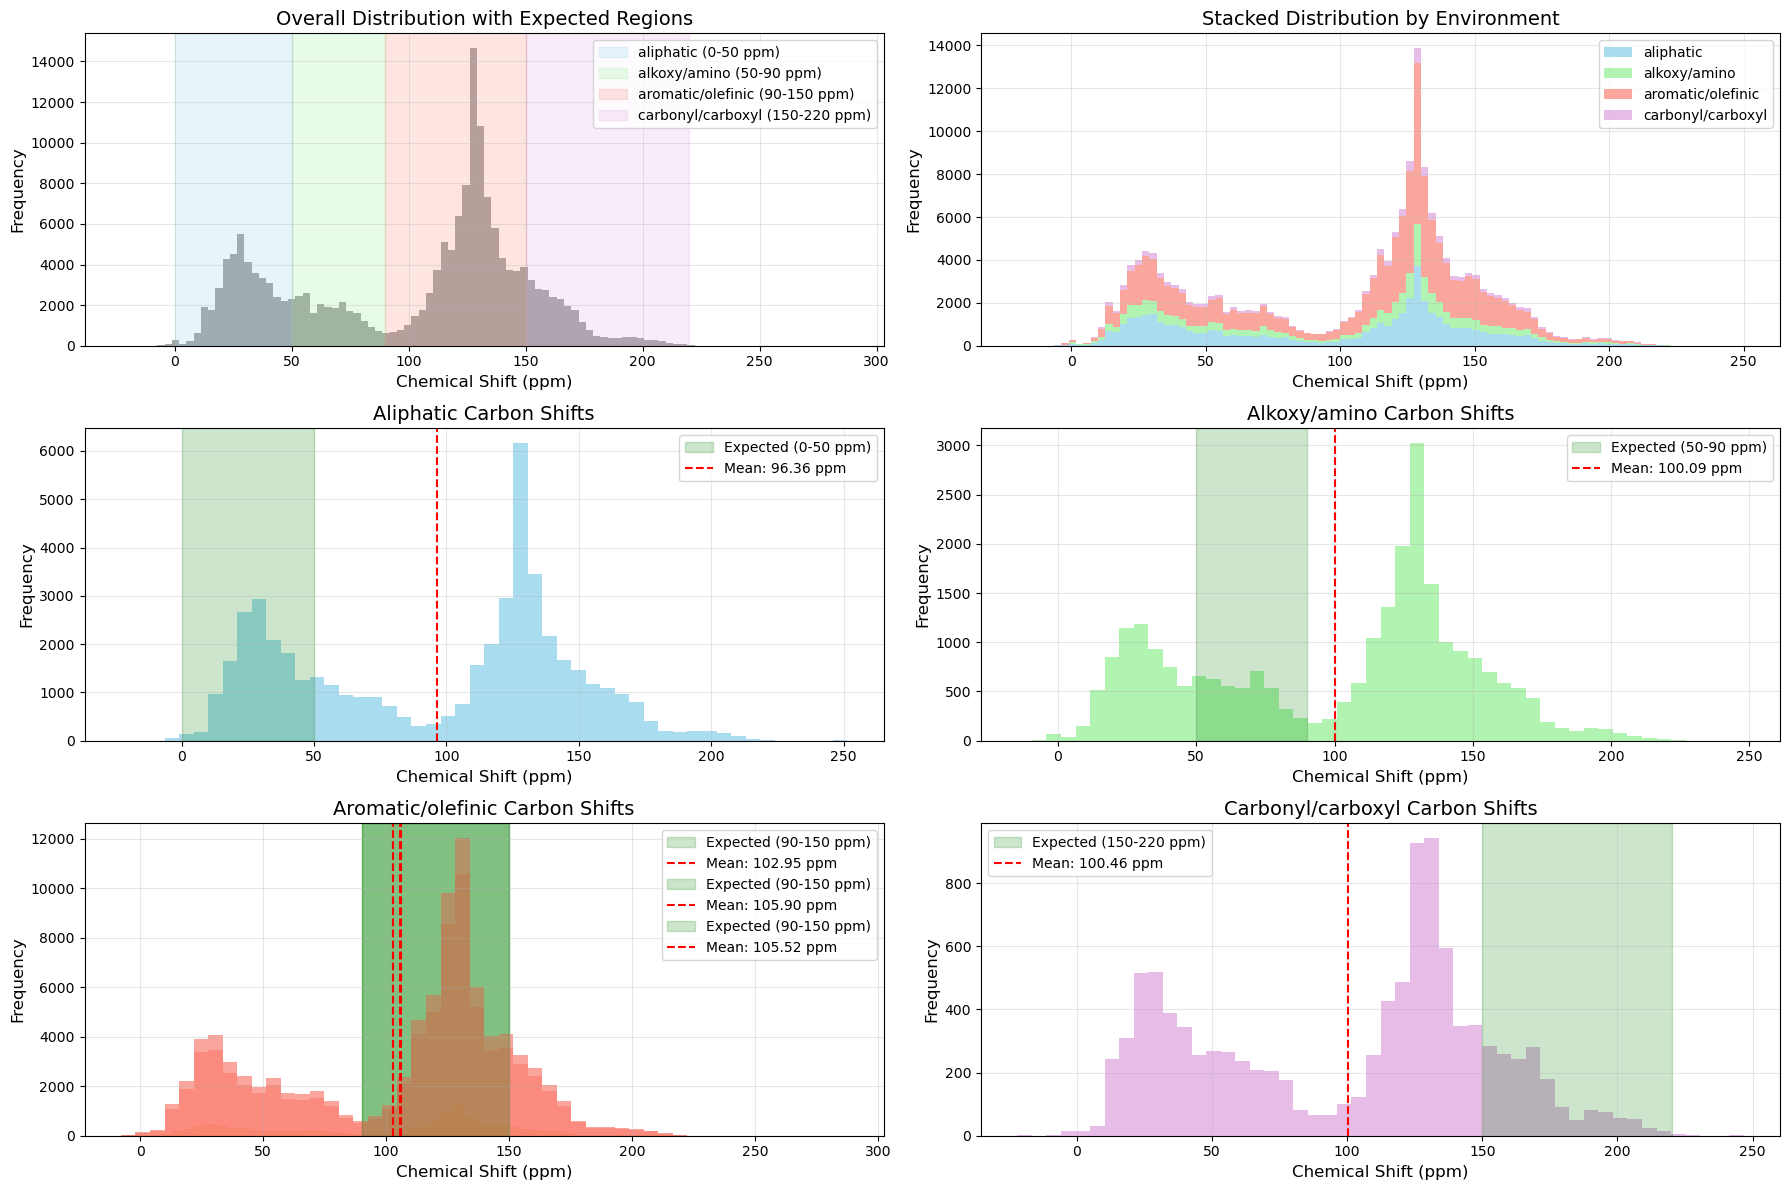

/tmp/ipykernel_265072/2179280469.py:236: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, patch_artist=True, labels=envs_to_plot)


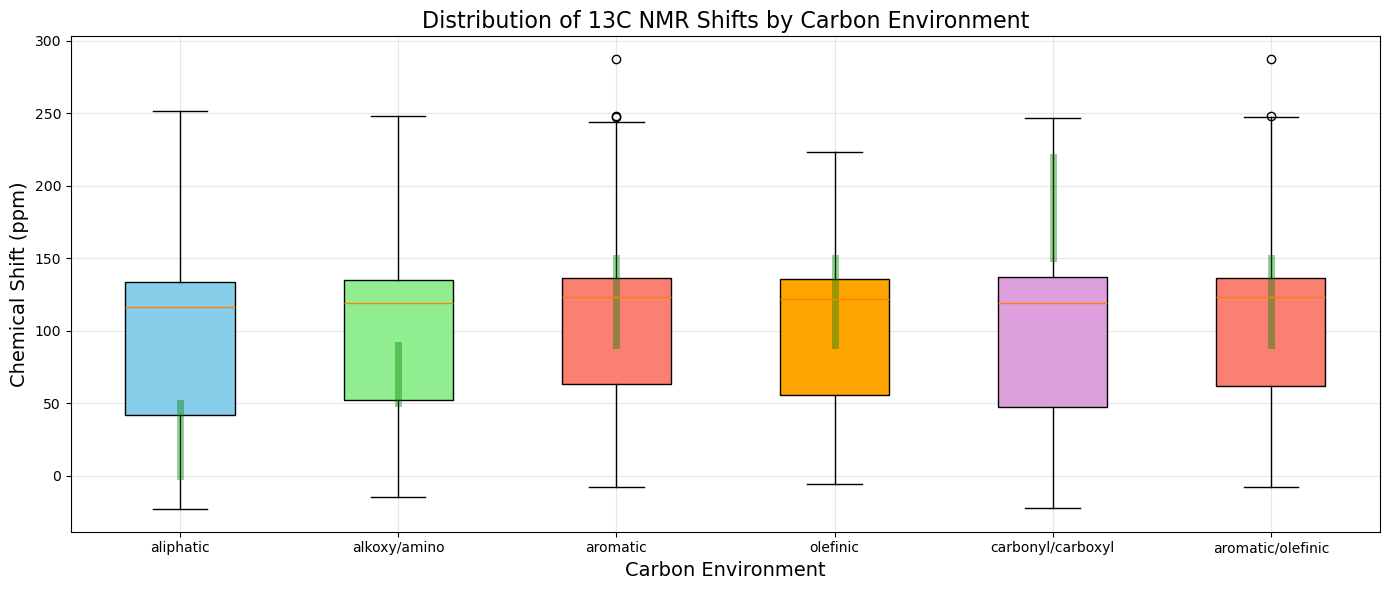


==== ENVIRONMENT OVERLAP ANALYSIS ====
Aliphatic: 28.5% of shifts are within expected range (0-50 ppm)
  - Below range: 95 shifts (0.2%)
  - Above range: 34984 shifts (71.3%)
Alkoxy/amino: 15.0% of shifts are within expected range (50-90 ppm)
  - Below range: 6369 shifts (23.9%)
  - Above range: 16253 shifts (61.1%)
Aromatic/olefinic: 54.3% of shifts are within expected range (90-150 ppm)
  - Below range: 29421 shifts (31.9%)
  - Above range: 12651 shifts (13.7%)
Carbonyl/carboxyl: 16.2% of shifts are within expected range (150-220 ppm)
  - Below range: 8761 shifts (83.7%)
  - Above range: 6 shifts (0.1%)


In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict
from rdkit import Chem

# Path to your HDF5 file
h5_file_path = "../data/processed/processed_data.h5"
# For this analysis, we'll need the original SD file to classify carbon environments
sd_file_path = "../data/raw/nmrshiftdb2withsignals.sd"  # Update with your actual SD file path

# Define carbon environments and their expected shift ranges
carbon_environments = {
    "aliphatic": (0, 50),
    "alkoxy/amino": (50, 90),
    "aromatic": (90, 150),
    "olefinic": (90, 150),
    "carbonyl/carboxyl": (150, 220)
}

# Function to classify a carbon atom's environment
def classify_carbon_environment(atom, mol):
    """Classify a carbon atom into structural categories based on its environment."""
    if atom.GetSymbol() != 'C':
        return "non-carbon"
        
    # Is it aromatic?
    if atom.GetIsAromatic():
        return "aromatic"
    
    # Check for carbonyl/carboxyl
    for neighbor in atom.GetNeighbors():
        if neighbor.GetSymbol() == 'O' and mol.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx()).GetBondType() == Chem.rdchem.BondType.DOUBLE:
            return "carbonyl/carboxyl"
    
    # Check for olefinic (C=C)
    for neighbor in atom.GetNeighbors():
        if neighbor.GetSymbol() == 'C' and mol.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx()).GetBondType() == Chem.rdchem.BondType.DOUBLE:
            return "olefinic"
    
    # Check for alkoxy/amino
    for neighbor in atom.GetNeighbors():
        if neighbor.GetSymbol() in ['O', 'N']:
            return "alkoxy/amino"
    
    # If none of the above, it's aliphatic
    return "aliphatic"

# Function to extract shifts with their carbon environment classification
def extract_shifts_with_environments(h5_file_path, sd_file_path):
    # Dictionary to store shifts by environment type
    environment_shifts = defaultdict(list)
    
    # Load molecules from SD file
    suppl = Chem.SDMolSupplier(sd_file_path)
    mols_dict = {}  # Dictionary to store molecules by index
    
    print("Loading molecules from SD file...")
    for idx, mol in enumerate(tqdm(suppl)):
        if mol is not None:
            mols_dict[idx] = mol
    
    # Load shifts from HDF5 file and match with environments
    print("Analyzing carbon environments and shifts...")
    with h5py.File(h5_file_path, 'r') as h5_file:
        for mol_key in tqdm(h5_file.keys(), desc="Processing molecules"):
            mol_idx = int(mol_key.split('_')[1])  # Extract molecule index
            
            # Skip if we can't find the molecule in our dictionary
            if mol_idx not in mols_dict:
                continue
                
            mol = mols_dict[mol_idx]
            mol_group = h5_file[mol_key]
            
            if 'y' in mol_group:
                shifts = mol_group['y'][:]
                
                # Classify each carbon in the molecule
                carbon_indices = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetSymbol() == 'C']
                
                # Make sure shift array is same length as number of carbons
                if len(shifts) >= len(carbon_indices):
                    for i, atom_idx in enumerate(carbon_indices):
                        if i < len(shifts) and not np.isnan(shifts[i]):
                            environment = classify_carbon_environment(mol.GetAtomWithIdx(atom_idx), mol)
                            environment_shifts[environment].append(shifts[i])
                
    return environment_shifts

# Extract shifts with their carbon environment classifications
environment_shifts = extract_shifts_with_environments(h5_file_path, sd_file_path)

# If you don't have access to the original SD file, you can use this alternative approach
# that simulates the environment classification based on shift ranges
def classify_shifts_by_range(all_shifts):
    # Dictionary to store shifts by environment type based on typical ranges
    environment_shifts = defaultdict(list)
    
    for shift in all_shifts:
        if 0 <= shift < 50:
            environment_shifts["aliphatic"].append(shift)
        elif 50 <= shift < 90:
            environment_shifts["alkoxy/amino"].append(shift)
        elif 90 <= shift < 150:
            environment_shifts["aromatic/olefinic"].append(shift)
        elif 150 <= shift <= 220:
            environment_shifts["carbonyl/carboxyl"].append(shift)
        else:
            environment_shifts["other"].append(shift)
            
    return environment_shifts

# Use this if you don't have access to the original SD file
# environment_shifts = classify_shifts_by_range(extract_all_shifts(h5_file_path))

# Print statistics for each environment
for env, shifts in environment_shifts.items():
    if len(shifts) > 0:
        shifts_arr = np.array(shifts)
        print(f"\n==== {env.upper()} CARBONS ====")
        print(f"Count: {len(shifts_arr)}")
        print(f"Mean shift: {np.mean(shifts_arr):.2f} ppm")
        print(f"Median shift: {np.median(shifts_arr):.2f} ppm")
        print(f"Standard deviation: {np.std(shifts_arr):.2f} ppm")
        print(f"Range: {np.min(shifts_arr):.2f} to {np.max(shifts_arr):.2f} ppm")

# Create a figure with histograms for each environment
plt.figure(figsize=(18, 12))

# Define colors for each environment
env_colors = {
    "aliphatic": "skyblue",
    "alkoxy/amino": "lightgreen",
    "aromatic": "salmon",
    "olefinic": "orange",
    "carbonyl/carboxyl": "plum",
    "aromatic/olefinic": "salmon",  # For the range-based classification
    "other": "gray"
}

# Define regions and their expected ranges
regions = [
    (0, 50, 'aliphatic', 'skyblue'),
    (50, 90, 'alkoxy/amino', 'lightgreen'),
    (90, 150, 'aromatic/olefinic', 'salmon'),
    (150, 220, 'carbonyl/carboxyl', 'plum')
]

# First subplot: Overall distribution with highlighted regions
plt.subplot(3, 2, 1)
all_shifts = np.concatenate([np.array(shifts) for shifts in environment_shifts.values()])
plt.hist(all_shifts, bins=100, alpha=0.7, color='gray')
for start, end, label, color in regions:
    plt.axvspan(start, end, alpha=0.2, color=color, label=f'{label} ({start}-{end} ppm)')
plt.title('Overall Distribution with Expected Regions', fontsize=14)
plt.xlabel('Chemical Shift (ppm)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Create separate subplots for each environment
subplot_positions = {
    "aliphatic": (3, 2, 3),
    "alkoxy/amino": (3, 2, 4),
    "aromatic": (3, 2, 5),
    "olefinic": (3, 2, 5),  # Sharing with aromatic
    "carbonyl/carboxyl": (3, 2, 6),
    "aromatic/olefinic": (3, 2, 5),  # For the range-based classification
    "other": (3, 2, 2)
}

# Combine aromatic and olefinic if separately classified
if "aromatic" in environment_shifts and "olefinic" in environment_shifts:
    combined = np.concatenate([environment_shifts["aromatic"], environment_shifts["olefinic"]])
    environment_shifts["aromatic/olefinic"] = combined
    
# Plot each environment's distribution
for env, shifts in environment_shifts.items():
    if len(shifts) > 0 and env in subplot_positions:
        shifts_arr = np.array(shifts)
        plt.subplot(*subplot_positions[env])
        
        # Get the expected range for this environment
        expected_range = None
        for start, end, label, color in regions:
            if label == env or (env in ["aromatic", "olefinic"] and label == "aromatic/olefinic"):
                expected_range = (start, end)
                break
        
        # Plot histogram
        plt.hist(shifts_arr, bins=50, alpha=0.7, color=env_colors.get(env, 'gray'))
        
        # Highlight the expected range if we have one
        if expected_range:
            plt.axvspan(expected_range[0], expected_range[1], alpha=0.2, color='green', 
                       label=f'Expected ({expected_range[0]}-{expected_range[1]} ppm)')
        
        # Add mean line
        plt.axvline(np.mean(shifts_arr), color='r', linestyle='--', 
                   label=f'Mean: {np.mean(shifts_arr):.2f} ppm')
        
        plt.title(f'{env.capitalize()} Carbon Shifts', fontsize=14)
        plt.xlabel('Chemical Shift (ppm)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()

# Create a stacked histogram to visualize how environments overlap
plt.subplot(3, 2, 2)
bin_edges = np.linspace(-20, 250, 100)
plt.hist([environment_shifts[env] for env in ["aliphatic", "alkoxy/amino", "aromatic/olefinic", "carbonyl/carboxyl", "other"] 
         if env in environment_shifts and len(environment_shifts[env]) > 0],
        bins=bin_edges, stacked=True, 
        label=[env for env in ["aliphatic", "alkoxy/amino", "aromatic/olefinic", "carbonyl/carboxyl", "other"] 
              if env in environment_shifts and len(environment_shifts[env]) > 0],
        alpha=0.7,
        color=[env_colors.get(env, 'gray') for env in ["aliphatic", "alkoxy/amino", "aromatic/olefinic", "carbonyl/carboxyl", "other"] 
              if env in environment_shifts and len(environment_shifts[env]) > 0])
plt.title('Stacked Distribution by Environment', fontsize=14)
plt.xlabel('Chemical Shift (ppm)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Create boxplots to compare the distributions
plt.figure(figsize=(14, 6))
envs_to_plot = [env for env in ["aliphatic", "alkoxy/amino", "aromatic", "olefinic", "carbonyl/carboxyl", "aromatic/olefinic", "other"] 
                if env in environment_shifts and len(environment_shifts[env]) > 0]
data_to_plot = [environment_shifts[env] for env in envs_to_plot]

box = plt.boxplot(data_to_plot, patch_artist=True, labels=envs_to_plot)

# Color the boxes
for patch, env in zip(box['boxes'], envs_to_plot):
    patch.set_facecolor(env_colors.get(env, 'gray'))

plt.title('Distribution of 13C NMR Shifts by Carbon Environment', fontsize=16)
plt.xlabel('Carbon Environment', fontsize=14)
plt.ylabel('Chemical Shift (ppm)', fontsize=14)
plt.grid(True, alpha=0.3)

# Add expected range markers
for i, env in enumerate(envs_to_plot):
    for start, end, label, color in regions:
        if label == env or (env in ["aromatic", "olefinic"] and label == "aromatic/olefinic"):
            plt.plot([i+1, i+1], [start, end], 'g-', linewidth=5, alpha=0.4)

plt.tight_layout()
plt.show()

# Calculate overlap statistics
print("\n==== ENVIRONMENT OVERLAP ANALYSIS ====")
for env, (min_expected, max_expected) in [(e, r) for r, e in zip([(0, 50), (50, 90), (90, 150), (150, 220)], 
                                                   ["aliphatic", "alkoxy/amino", "aromatic/olefinic", "carbonyl/carboxyl"])
                                        if e in environment_shifts]:
    shifts = np.array(environment_shifts[env])
    in_expected_range = ((shifts >= min_expected) & (shifts <= max_expected)).sum()
    percentage_in_range = (in_expected_range / len(shifts)) * 100 if len(shifts) > 0 else 0
    
    print(f"{env.capitalize()}: {percentage_in_range:.1f}% of shifts are within expected range ({min_expected}-{max_expected} ppm)")
    
    # Show out-of-range distribution
    below_range = (shifts < min_expected).sum()
    above_range = (shifts > max_expected).sum()
    
    if len(shifts) > 0:
        print(f"  - Below range: {below_range} shifts ({(below_range/len(shifts))*100:.1f}%)")
        print(f"  - Above range: {above_range} shifts ({(above_range/len(shifts))*100:.1f}%)")


Extracting shifts by environment:   0%|          | 0/32937 [00:00<?, ?it/s]

Total number of 13C shifts: 356098
Mean shift: 95.54 ppm
Median shift: 115.90 ppm
Standard deviation: 51.61 ppm
Range: -45.80 to 333.80 ppm

==== ALIPHATIC CARBONS ====
Count: 104129
Mean shift: 31.45 ppm
Median shift: 28.20 ppm
Standard deviation: 18.47 ppm
Range: -45.80 to 333.80 ppm

==== OLEFINIC CARBONS ====
Count: 23138
Mean shift: 130.91 ppm
Median shift: 131.30 ppm
Standard deviation: 19.80 ppm
Range: -7.50 to 238.50 ppm

==== ALKOXY/AMINO CARBONS ====
Count: 52653
Mean shift: 69.49 ppm
Median shift: 64.70 ppm
Standard deviation: 25.11 ppm
Range: 8.80 to 234.00 ppm

==== CARBONYL/CARBOXYL CARBONS ====
Count: 20963
Mean shift: 176.59 ppm
Median shift: 171.90 ppm
Standard deviation: 17.19 ppm
Range: 7.90 to 248.80 ppm

==== AROMATIC CARBONS ====
Count: 154707
Mean shift: 131.28 ppm
Median shift: 129.10 ppm
Standard deviation: 15.04 ppm
Range: 17.80 to 232.40 ppm


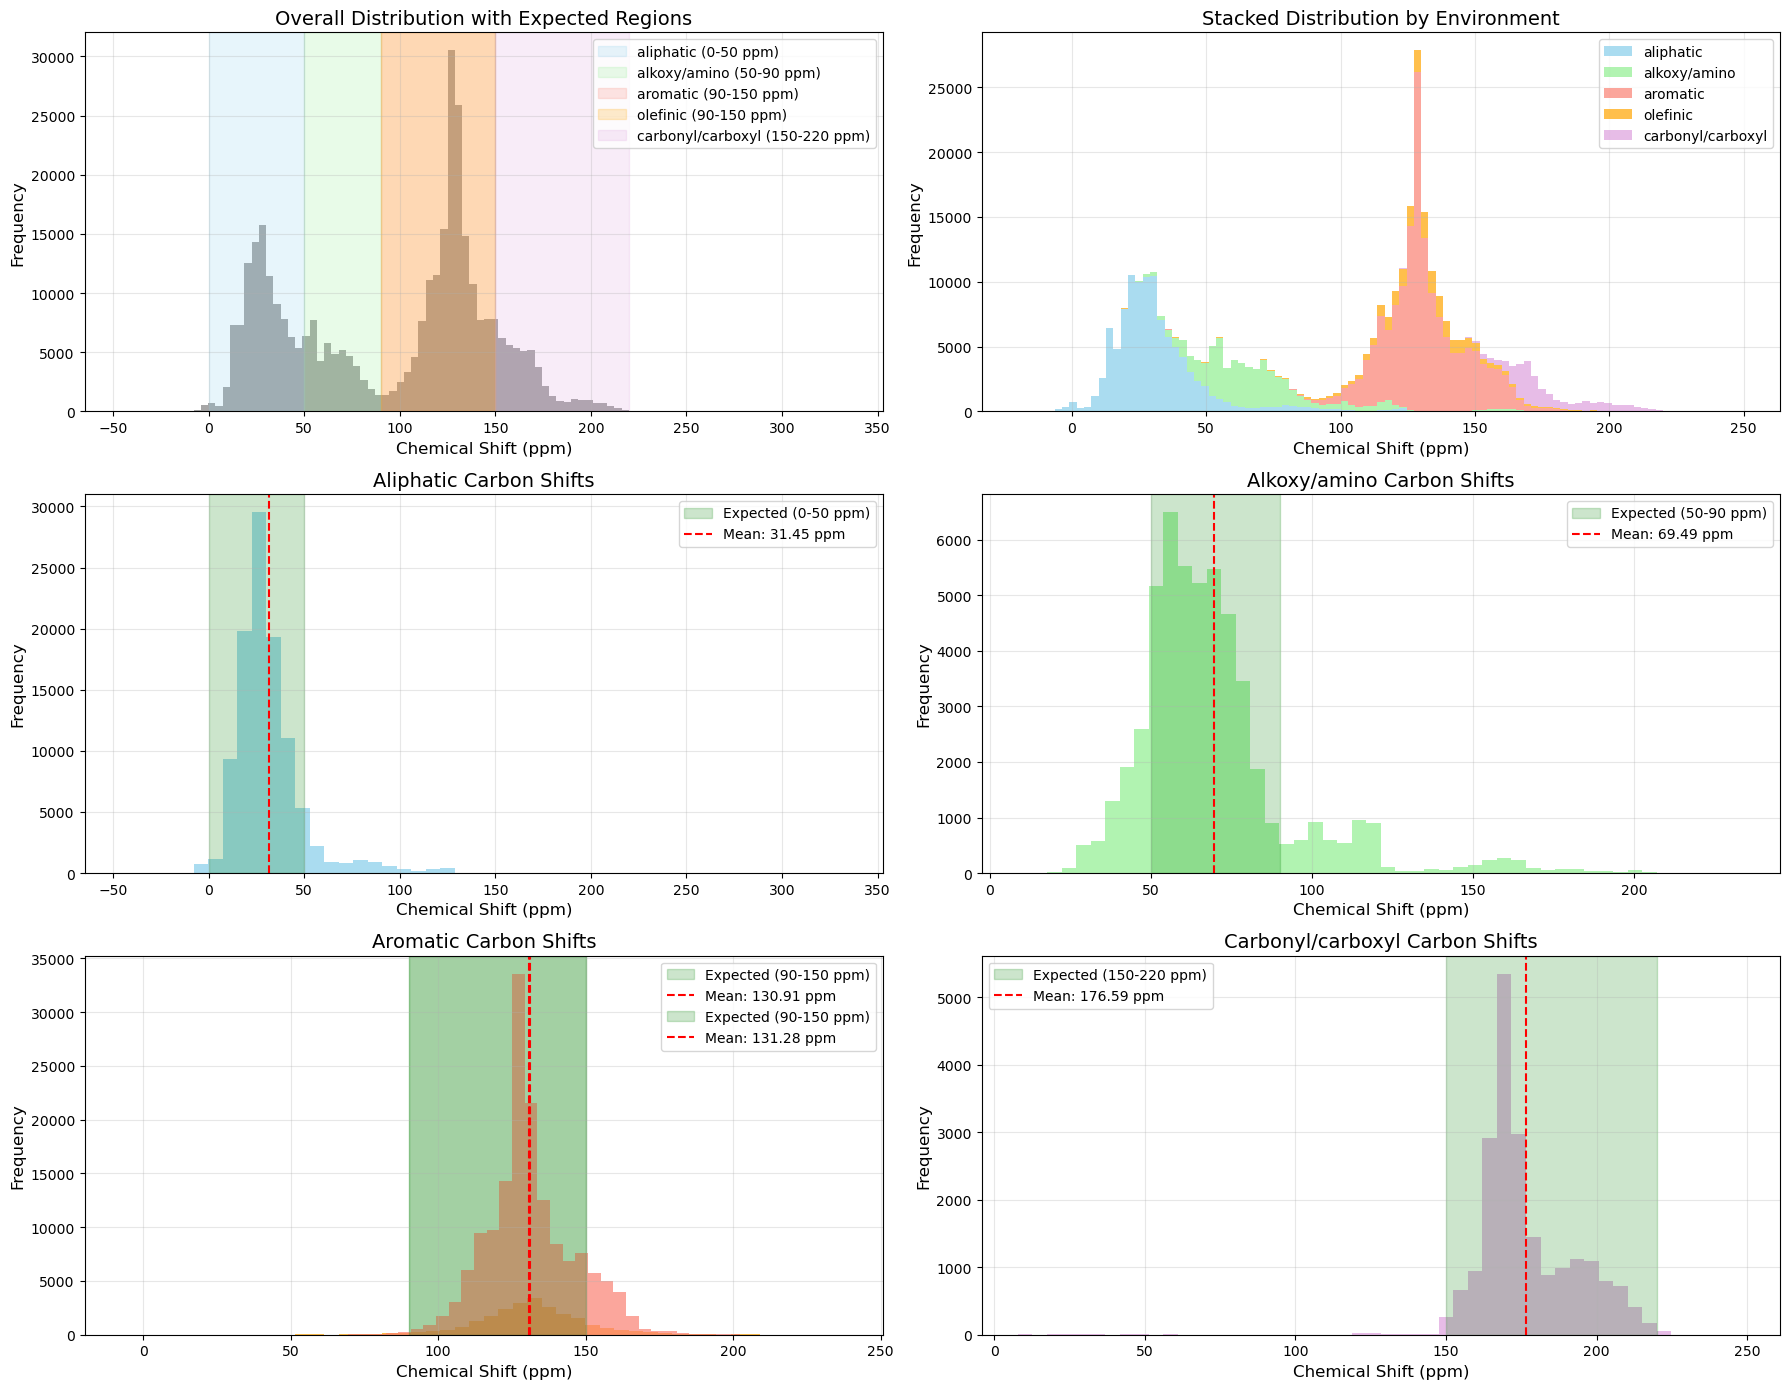

/tmp/ipykernel_265072/42301744.py:164: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, patch_artist=True, labels=env_to_plot)


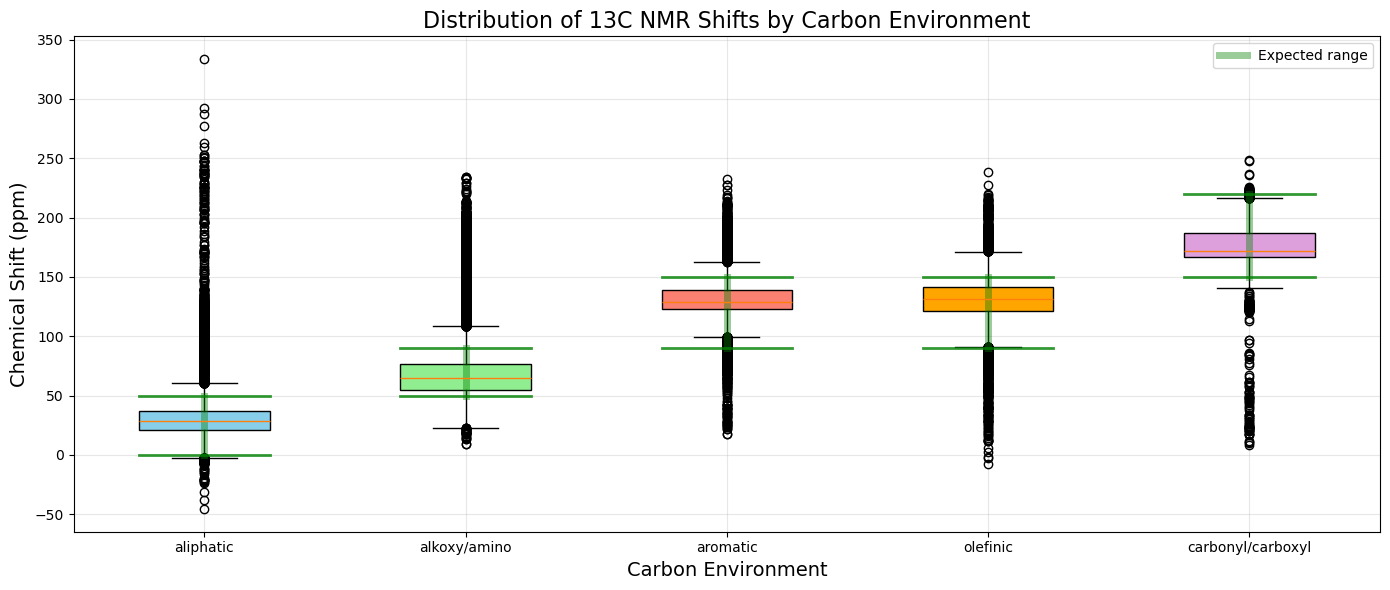


==== ENVIRONMENT OVERLAP ANALYSIS ====
Aliphatic: 90.2% of shifts are within expected range (0-50 ppm)
  - Below range: 867 shifts (0.8%)
  - Above range: 9363 shifts (9.0%)
  - Most common shifts below range: around -1.4 ppm
  - Most common shifts above range: around 68.8 ppm
Alkoxy/amino: 73.0% of shifts are within expected range (50-90 ppm)
  - Below range: 7413 shifts (14.1%)
  - Above range: 6808 shifts (12.9%)
  - Most common shifts below range: around 43.1 ppm
  - Most common shifts above range: around 113.9 ppm
Aromatic: 87.2% of shifts are within expected range (90-150 ppm)
  - Below range: 539 shifts (0.3%)
  - Above range: 19330 shifts (12.5%)
  - Most common shifts below range: around 83.6 ppm
  - Most common shifts above range: around 157.4 ppm
Olefinic: 84.8% of shifts are within expected range (90-150 ppm)
  - Below range: 650 shifts (2.8%)
  - Above range: 2859 shifts (12.4%)
  - Most common shifts below range: around 78.4 ppm
  - Most common shifts above range: around

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict

# Path to your HDF5 file
h5_file_path = "../data/processed/processed_data.h5"

# Function to extract NMR shifts with carbon environment information
def extract_shifts_with_environments(h5_file_path):
    # Dictionary to store shifts by environment type
    environment_shifts = defaultdict(list)
    environment_types = ["non-carbon", "aliphatic", "alkoxy/amino", "aromatic", "olefinic", "carbonyl/carboxyl"]
    
    with h5py.File(h5_file_path, 'r') as f:
        for mol_key in tqdm(f.keys(), desc="Extracting shifts by environment"):
            mol_group = f[mol_key]
            
            if 'x' in mol_group and 'y' in mol_group:
                # Get atom features and shifts
                atom_features = mol_group['x'][:]
                shifts = mol_group['y'][:]
                
                # For each atom with a valid shift
                for i in range(len(shifts)):
                    if i < len(atom_features) and not np.isnan(shifts[i]):
                        # Extract the environment one-hot encoding
                        # The environment features start at index -6 (last 6 values in the feature vector)
                        env_encoding = atom_features[i][-6:]
                        
                        # Find which environment this atom belongs to
                        if np.max(env_encoding) > 0:  # Check if any environment is encoded
                            env_index = np.argmax(env_encoding)
                            env_type = environment_types[env_index]
                            environment_shifts[env_type].append(shifts[i])
    
    return environment_shifts

# Extract shifts with their carbon environment classifications
environment_shifts = extract_shifts_with_environments(h5_file_path)

# All shifts for overall statistics
all_shifts = []
for shifts in environment_shifts.values():
    all_shifts.extend(shifts)
all_shifts = np.array(all_shifts)

# Print overall statistics
print(f"Total number of 13C shifts: {len(all_shifts)}")
print(f"Mean shift: {np.mean(all_shifts):.2f} ppm")
print(f"Median shift: {np.median(all_shifts):.2f} ppm")
print(f"Standard deviation: {np.std(all_shifts):.2f} ppm")
print(f"Range: {np.min(all_shifts):.2f} to {np.max(all_shifts):.2f} ppm")

# Print statistics for each environment
for env, shifts in environment_shifts.items():
    if len(shifts) > 0 and env != "non-carbon":  # Skip non-carbon environment
        shifts_arr = np.array(shifts)
        print(f"\n==== {env.upper()} CARBONS ====")
        print(f"Count: {len(shifts_arr)}")
        print(f"Mean shift: {np.mean(shifts_arr):.2f} ppm")
        print(f"Median shift: {np.median(shifts_arr):.2f} ppm")
        print(f"Standard deviation: {np.std(shifts_arr):.2f} ppm")
        print(f"Range: {np.min(shifts_arr):.2f} to {np.max(shifts_arr):.2f} ppm")

# Define expected regions for each environment
regions = [
    ("aliphatic", 0, 50, "skyblue"),
    ("alkoxy/amino", 50, 90, "lightgreen"),
    ("aromatic", 90, 150, "salmon"),
    ("olefinic", 90, 150, "orange"),
    ("carbonyl/carboxyl", 150, 220, "plum")
]

# Create a figure with multiple subplots
plt.figure(figsize=(18, 14))

# Plot overall distribution with environment regions highlighted
plt.subplot(3, 2, 1)
plt.hist(all_shifts, bins=100, alpha=0.7, color='gray')
for env, start, end, color in regions:
    plt.axvspan(start, end, alpha=0.2, color=color, label=f'{env} ({start}-{end} ppm)')
plt.title('Overall Distribution with Expected Regions', fontsize=14)
plt.xlabel('Chemical Shift (ppm)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Create individual histograms for each environment
env_positions = {
    "aliphatic": (3, 2, 3),
    "alkoxy/amino": (3, 2, 4),
    "aromatic": (3, 2, 5),
    "olefinic": (3, 2, 5),  # Could overlap with aromatic, adjust as needed
    "carbonyl/carboxyl": (3, 2, 6)
}

# Colors for each environment
env_colors = {
    "aliphatic": "skyblue",
    "alkoxy/amino": "lightgreen",
    "aromatic": "salmon",
    "olefinic": "orange",
    "carbonyl/carboxyl": "plum"
}

# Plot each environment's distribution
for env, shifts in environment_shifts.items():
    if len(shifts) > 0 and env != "non-carbon" and env in env_positions:
        shifts_arr = np.array(shifts)
        plt.subplot(*env_positions[env])
        
        # Plot histogram
        plt.hist(shifts_arr, bins=50, alpha=0.7, color=env_colors.get(env, 'gray'))
        
        # Find the expected range for this environment
        expected_range = None
        for region_env, start, end, color in regions:
            if region_env == env:
                expected_range = (start, end)
                # Highlight expected range
                plt.axvspan(start, end, alpha=0.2, color='green', 
                           label=f'Expected ({start}-{end} ppm)')
                break
        
        # Add mean line
        plt.axvline(np.mean(shifts_arr), color='r', linestyle='--', 
                   label=f'Mean: {np.mean(shifts_arr):.2f} ppm')
        
        plt.title(f'{env.capitalize()} Carbon Shifts', fontsize=14)
        plt.xlabel('Chemical Shift (ppm)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)

# Create stacked histogram to visualize overlap
plt.subplot(3, 2, 2)
bin_edges = np.linspace(-20, 250, 100)
env_to_plot = [env for env in ["aliphatic", "alkoxy/amino", "aromatic", "olefinic", "carbonyl/carboxyl"] 
              if env in environment_shifts and len(environment_shifts[env]) > 0]

plt.hist([environment_shifts[env] for env in env_to_plot],
        bins=bin_edges, stacked=True, 
        label=env_to_plot,
        alpha=0.7,
        color=[env_colors[env] for env in env_to_plot])

plt.title('Stacked Distribution by Environment', fontsize=14)
plt.xlabel('Chemical Shift (ppm)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create boxplots to compare the distributions
plt.figure(figsize=(14, 6))
env_to_plot = [env for env in ["aliphatic", "alkoxy/amino", "aromatic", "olefinic", "carbonyl/carboxyl"] 
              if env in environment_shifts and len(environment_shifts[env]) > 0]
data_to_plot = [environment_shifts[env] for env in env_to_plot]

box = plt.boxplot(data_to_plot, patch_artist=True, labels=env_to_plot)

# Color the boxes
for patch, env in zip(box['boxes'], env_to_plot):
    patch.set_facecolor(env_colors[env])

# Add expected ranges as horizontal bars
for i, env in enumerate(env_to_plot):
    for region_env, start, end, color in regions:
        if region_env == env:
            plt.plot([i+0.75, i+1.25], [start, start], 'g-', linewidth=2, alpha=0.8)
            plt.plot([i+0.75, i+1.25], [end, end], 'g-', linewidth=2, alpha=0.8)
            plt.plot([i+1, i+1], [start, end], 'g-', linewidth=5, alpha=0.4, 
                    label='Expected range' if i == 0 else "")

plt.title('Distribution of 13C NMR Shifts by Carbon Environment', fontsize=16)
plt.xlabel('Carbon Environment', fontsize=14)
plt.ylabel('Chemical Shift (ppm)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Calculate overlap statistics
print("\n==== ENVIRONMENT OVERLAP ANALYSIS ====")
for env, (min_expected, max_expected) in [(region_env, (start, end)) 
                                        for region_env, start, end, color in regions 
                                        if region_env in environment_shifts]:
    
    shifts = np.array(environment_shifts[env])
    if len(shifts) > 0:
        in_expected_range = ((shifts >= min_expected) & (shifts <= max_expected)).sum()
        percentage_in_range = (in_expected_range / len(shifts)) * 100
        
        print(f"{env.capitalize()}: {percentage_in_range:.1f}% of shifts are within expected range ({min_expected}-{max_expected} ppm)")
        
        # Show out-of-range distribution
        below_range = (shifts < min_expected).sum()
        above_range = (shifts > max_expected).sum()
        
        print(f"  - Below range: {below_range} shifts ({(below_range/len(shifts))*100:.1f}%)")
        print(f"  - Above range: {above_range} shifts ({(above_range/len(shifts))*100:.1f}%)")
        
        # Most common shifts outside of range
        if below_range > 0:
            below_shifts = shifts[shifts < min_expected]
            print(f"  - Most common shifts below range: around {np.median(below_shifts):.1f} ppm")
            
        if above_range > 0:
            above_shifts = shifts[shifts > max_expected]
            print(f"  - Most common shifts above range: around {np.median(above_shifts):.1f} ppm")
